# Customer Segmentation

We will be using E-commerce dataset of user purchases and try develop a model that allow us to do two things:

1. Classifying customers into segments.
2. Anticipate the purchases that will be made by a new customer, during the following year and 
   this, from its first purchase by assigning them appropriate cluster/segment 


In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
#import plotly.plotly as py
#import plotly.graph_objs as go
#from plotly.offline import init_notebook_mode,iplot
#init_notebook_mode(connected=True)
#warnings.filterwarnings("ignore")
#plt.rcParams["patch.force_edgecolor"] = True
#plt.style.use('fivethirtyeight')
#mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

# **  Data Preparation **

In [2]:
#Reading train and test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [4]:
#Let us have a look at the structure of data in each file
print("Train data structure -> ","Rows: ",train.shape[0],'\t',"Cols: ",train.shape[1])
print("Test data structure ->", "Rows: ",test.shape[0],'\t',"Cols: ",test.shape[1])

Train data structure ->  Rows:  8068 	 Cols:  11
Test data structure -> Rows:  2627 	 Cols:  10


In [5]:
train.head(10).append(train.tail(10))

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A
5,461319,Male,Yes,56,No,Artist,0.0,Average,2.0,Cat_6,C
6,460156,Male,No,32,Yes,Healthcare,1.0,Low,3.0,Cat_6,C
7,464347,Female,No,33,Yes,Healthcare,1.0,Low,3.0,Cat_6,D
8,465015,Female,Yes,61,Yes,Engineer,0.0,Low,3.0,Cat_7,D
9,465176,Female,Yes,55,Yes,Artist,1.0,Average,4.0,Cat_6,C


In [6]:
train.isnull().sum()

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [7]:
train['Gender'].unique()

array(['Male', 'Female'], dtype=object)

In [8]:
train['Profession'].unique()

array(['Healthcare', 'Engineer', 'Lawyer', 'Entertainment', 'Artist',
       'Executive', 'Doctor', 'Homemaker', 'Marketing', nan], dtype=object)

In [9]:
train['Spending_Score'].unique()

array(['Low', 'Average', 'High'], dtype=object)

In [10]:
train['Var_1'].unique()

array(['Cat_4', 'Cat_6', 'Cat_7', 'Cat_3', 'Cat_1', 'Cat_2', nan, 'Cat_5'],
      dtype=object)

In [11]:
train['Segmentation'].unique()

array(['D', 'A', 'B', 'C'], dtype=object)

In [12]:
#use of simple map function 
map_Gender ={"Male" : 1 , "Female" : 2}
train['Gender'] = train['Gender'].map(map_Gender)

In [13]:
map_Ever_Married ={"Yes" : 0 , "No" : 1}
train['Ever_Married'] = train['Ever_Married'].map(map_Ever_Married)

In [14]:
map_Graduated ={"Yes" : 0 , "No" : 1}
train['Graduated'] = train['Graduated'].map(map_Graduated)

In [15]:
map_Spending_Score ={"Low" : 1 , "Average" : 2 , "High" : 3 }
train['Spending_Score'] = train['Spending_Score'].map(map_Spending_Score)

In [16]:
map_Var_1 ={"Cat_1" : 1 , "Cat_2" : 2 , "Cat_3" : 3 , "Cat_4" : 4 , "Cat_5" : 5 , "Cat_6" : 6 , "Cat_7" : 7 }
train['Var_1'] = train['Var_1'].map(map_Var_1)

In [17]:
map_Profession ={"Healthcare" : 1 , "Engineer" : 2 , "Lawyer" : 3 , "Entertainment" : 4 , "Artist" : 5 , "Executive" : 6 , "Doctor" : 7 , "Homemaker" : 8 , "Marketing" : 9 }
train['Profession'] = train['Profession'].map(map_Profession)

In [18]:
map_Segmentation ={"A" : 1 , "B" : 2 , "C" : 3 , "D" : 4}
train['Segmentation'] = train['Segmentation'].map(map_Segmentation)

In [19]:
 train.head(10).append(train.tail(10))

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,1,1.0,22,1.0,1.0,1.0,1,4.0,4.0,4
1,462643,2,0.0,38,0.0,2.0,NaN,2,3.0,4.0,1
2,466315,2,0.0,67,0.0,2.0,1.0,1,1.0,6.0,2
3,461735,1,0.0,67,0.0,3.0,0.0,3,2.0,6.0,2
4,462669,2,0.0,40,0.0,4.0,NaN,3,6.0,6.0,1
5,461319,1,0.0,56,1.0,5.0,0.0,2,2.0,6.0,3
6,460156,1,1.0,32,0.0,1.0,1.0,1,3.0,6.0,3
7,464347,2,1.0,33,0.0,1.0,1.0,1,3.0,6.0,4
8,465015,2,0.0,61,0.0,2.0,0.0,1,3.0,7.0,4
9,465176,2,0.0,55,0.0,5.0,1.0,2,4.0,6.0,3


In [20]:
display(train.describe())

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
count,8068.000000,8068.000000,7928.000000,8068.000000,7990.000000,7944.000000,7239.000000,8068.000000,7733.000000,7992.000000,8068.000000
mean,463479.214551,1.452529,0.414354,43.466906,0.378223,4.277568,2.641663,1.546108,2.850123,5.139264,2.561973
std,2595.381232,0.497772,0.492641,16.711696,0.484974,2.162217,3.406763,0.741202,1.531413,1.423738,1.139029
min,458982.000000,1.000000,0.000000,18.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,461240.750000,1.000000,0.000000,30.000000,0.000000,2.000000,0.000000,1.000000,2.000000,4.000000,2.000000
50%,463472.500000,1.000000,0.000000,40.000000,0.000000,5.000000,1.000000,1.000000,3.000000,6.000000,3.000000
75%,465744.250000,2.000000,1.000000,53.000000,1.000000,5.000000,4.000000,2.000000,4.000000,6.000000,4.000000
max,467974.000000,2.000000,1.000000,89.000000,1.000000,9.000000,14.000000,3.000000,9.000000,7.000000,4.000000


In [21]:
train.isnull().sum()

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [22]:
train.loc[(train['Family_Size'].isnull() == True), 'Family_Size'] = train['Family_Size'].mean()

In [23]:
train.loc[(train['Work_Experience'].isnull() == True), 'Work_Experience'] = train['Work_Experience'].mean()

In [24]:
train.loc[(train['Ever_Married'].isnull() == True), 'Ever_Married'] = train['Ever_Married'].mean()

In [25]:
train.loc[(train['Var_1'].isnull() == True), 'Var_1'] = train['Var_1'].mean()

In [26]:
train.loc[(train['Graduated'].isnull() == True), 'Graduated'] = train['Graduated'].mean()

In [27]:
train.loc[(train['Profession'].isnull() == True), 'Profession'] = train['Profession'].mean()

In [28]:
train.drop('ID', axis = 1 , inplace = True)

C:\Users\Asus\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Asus\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Asus\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` 

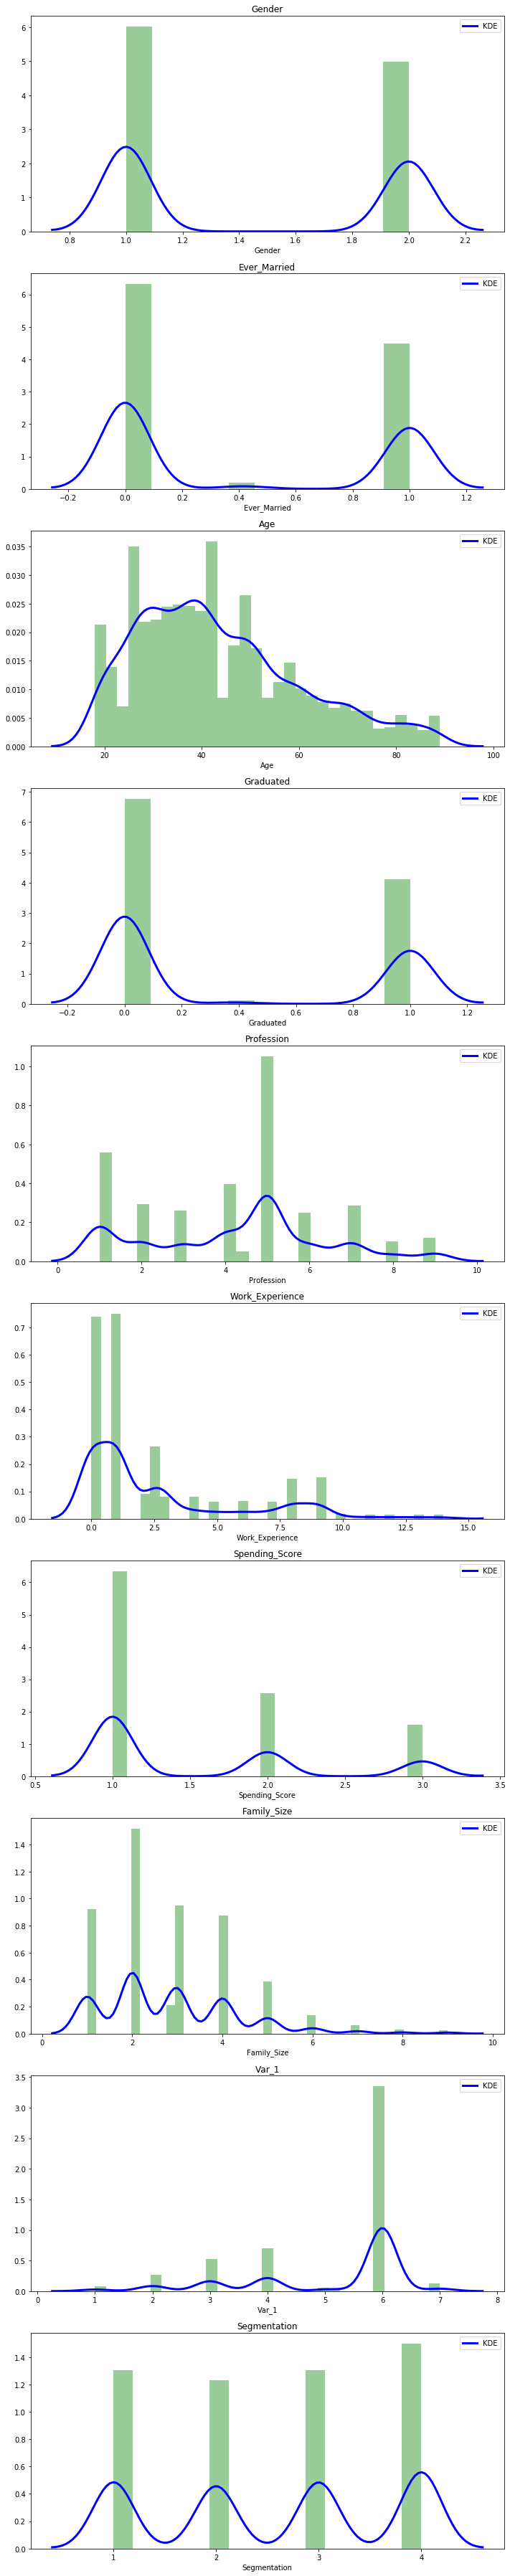

In [29]:
plt.figure(figsize=(10,50))
for i in range(len(train.columns)):
  plt.subplot(10, 1, i+1)
  sns.distplot(train[train.columns[i]], kde_kws={"color": "b", "lw": 3, "label": "KDE"}, hist_kws={"color": "g"})
  plt.title(train.columns[i])

plt.tight_layout()

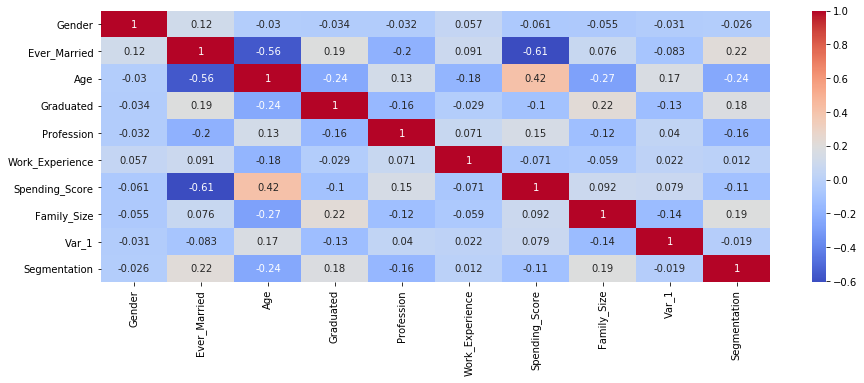

In [30]:
# Check product correlation
plt.subplots(figsize=(15,5))
sns.heatmap(train.corr(),cmap='coolwarm',annot=True)

In [31]:
print('Duplicate data entries: {}'.format(train.duplicated().sum()))
train.drop_duplicates(inplace = True)

Duplicate data entries: 417


In [33]:
#x = train.values #returns a numpy array
#min_max_scaler = preprocessing.MinMaxScaler()
#x_scaled = min_max_scaler.fit_transform(x)
#train = pd.DataFrame(x_scaled)

# APPLY K MEAN

In [34]:
# Let's scale the data first
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)

In [35]:
train_scaled.shape

(7651, 10)

In [36]:
train_scaled

array([[-0.91534546,  1.21236706, -1.30622616, ...,  0.75726375,
        -0.77277396,  1.28562748],
       [ 1.0924837 , -0.84026407, -0.33795049, ...,  0.09728153,
        -0.77277396, -1.34698984],
       [ 1.0924837 , -0.84026407,  1.41704918, ..., -1.2226829 ,
         0.62306736, -0.46945073],
       ...,
       [-0.91534546,  1.21236706, -0.51950218, ...,  0.75726375,
        -0.77277396,  1.28562748],
       [ 1.0924837 ,  1.21236706, -1.00364001, ...,  0.75726375,
         0.62306736, -0.46945073],
       [-0.91534546, -0.84026407, -0.39846772, ...,  0.09728153,
        -0.77277396, -0.46945073]])

In [46]:
kmeans.fit(train_scaled[:,:7])


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

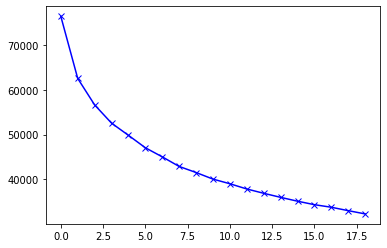

In [52]:
score_1 = []
range_values = range(1,20)

for i in range_values:
    kmeans = KMeans(n_clusters =i)
    kmeans.fit(train_scaled)
    score_1.append(kmeans.inertia_)
    
plt.plot(score_1, 'bx-')

In [ ]:
#above is optimal

In [41]:
kmeans = KMeans(4)
kmeans.fit(train_scaled)
labels = kmeans.labels_

In [42]:
kmeans.cluster_centers_.shape

(4, 10)

In [43]:
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [train.columns])
cluster_centers

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,-0.185921,-0.802987,0.523487,1.293633,0.092070,-0.138303,0.594303,0.034403,-0.033197,-0.279640
1,0.015625,1.088920,-0.994287,0.726095,-0.880989,-0.027888,-0.704400,0.760723,-0.302035,0.925210
2,0.326182,1.055411,-0.353671,-0.324952,0.475296,0.369473,-0.729554,-0.585561,0.090727,-0.406102
3,-0.109956,-0.825969,0.504328,-0.770023,0.167523,-0.131457,0.527967,-0.096226,0.125914,-0.148499


In [44]:
# In order to understand what these numbers mean, let's perform inverse transformation
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [train.columns])
cluster_centers

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,1.363290,0.018161,52.234577,0.999526,4.528175,2.268082,1.987053,2.904727,5.059686,2.216299
1,1.463670,0.939859,27.154557,0.726017,2.446972,2.628294,1.023399,4.005241,4.674487,3.589286
2,1.618343,0.923534,37.740237,0.219493,5.347828,3.924630,1.004734,1.965362,5.237248,2.072189
3,1.401124,0.006964,51.917989,0.005003,4.689555,2.290415,1.937831,2.706799,5.287665,2.365741


In [47]:
y_kmeans = kmeans.fit_predict(train_scaled)
y_kmeans

array([0, 3, 3, ..., 0, 0, 1])

In [48]:
# concatenate the clusters labels to our original dataframe
train_cluster = pd.concat([train, pd.DataFrame({'cluster':labels})], axis = 1)
train_cluster.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,cluster
0,1.0,1.0,22.0,1.0,1.0,1.000000,1.0,4.0,4.0,4.0,1.0
1,2.0,0.0,38.0,0.0,2.0,2.641663,2.0,3.0,4.0,1.0,3.0
2,2.0,0.0,67.0,0.0,2.0,1.000000,1.0,1.0,6.0,2.0,3.0
3,1.0,0.0,67.0,0.0,3.0,0.000000,3.0,2.0,6.0,2.0,3.0
4,2.0,0.0,40.0,0.0,4.0,2.641663,3.0,6.0,6.0,1.0,3.0


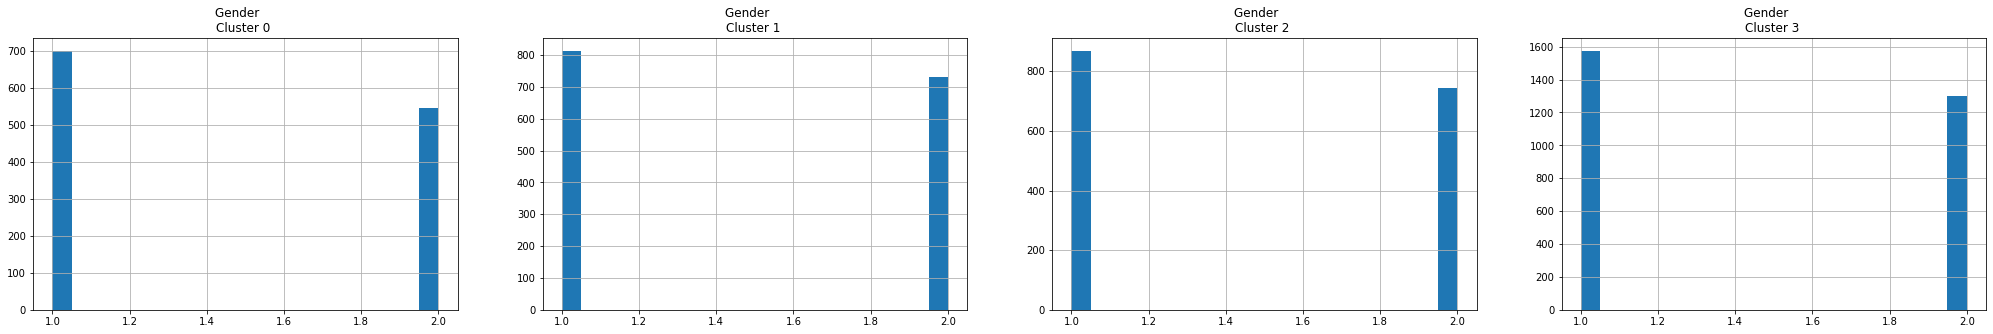

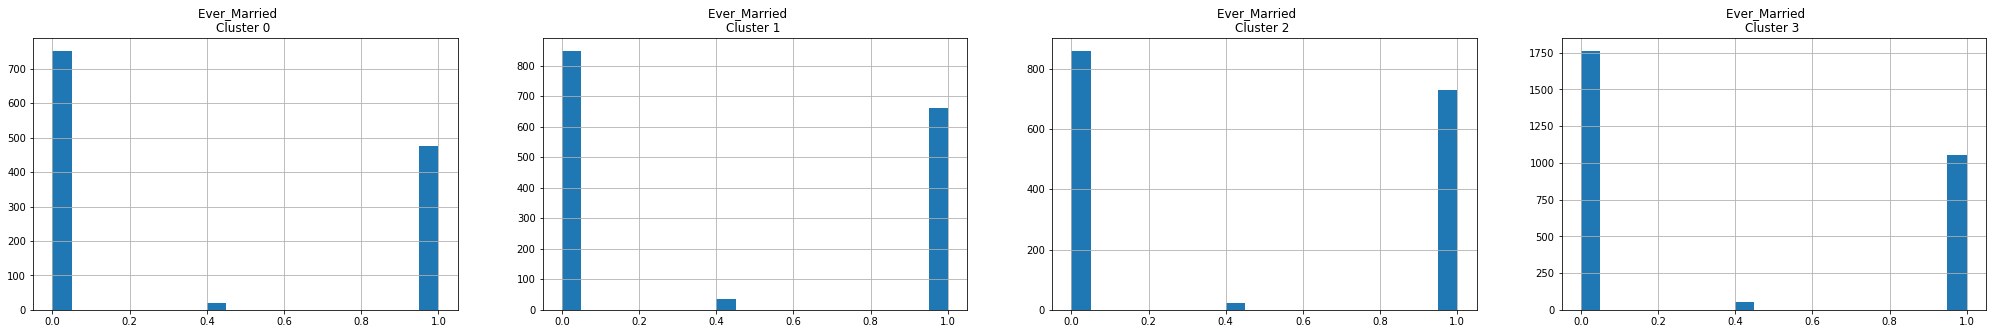

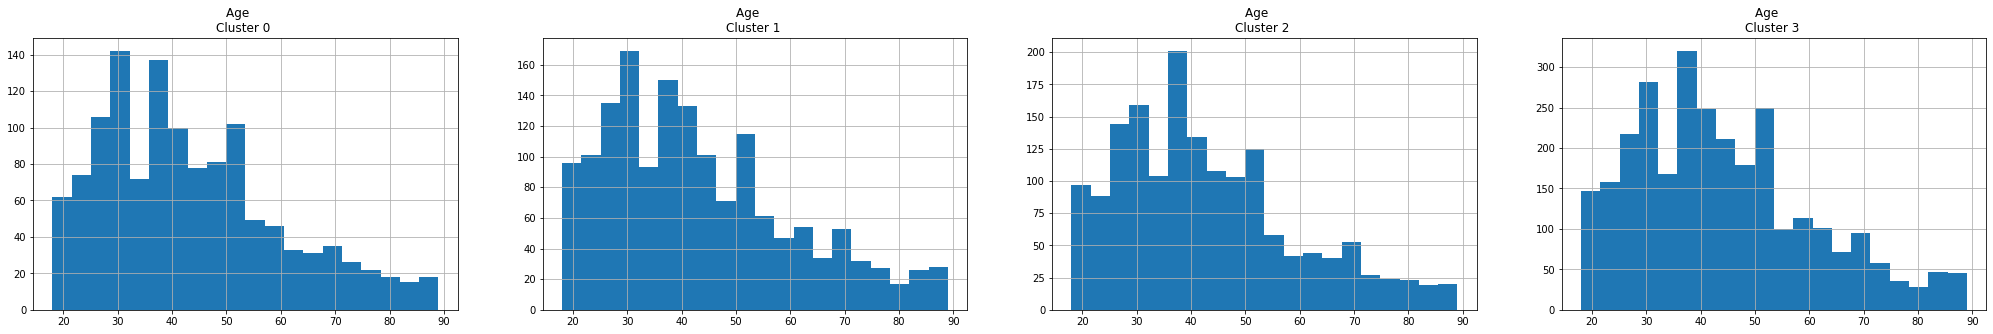

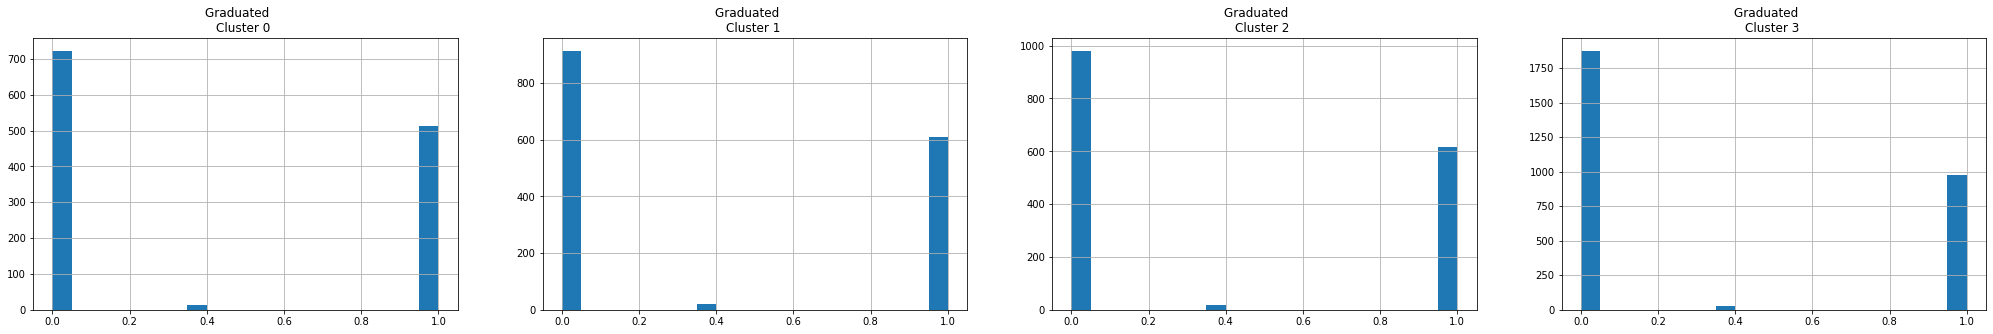

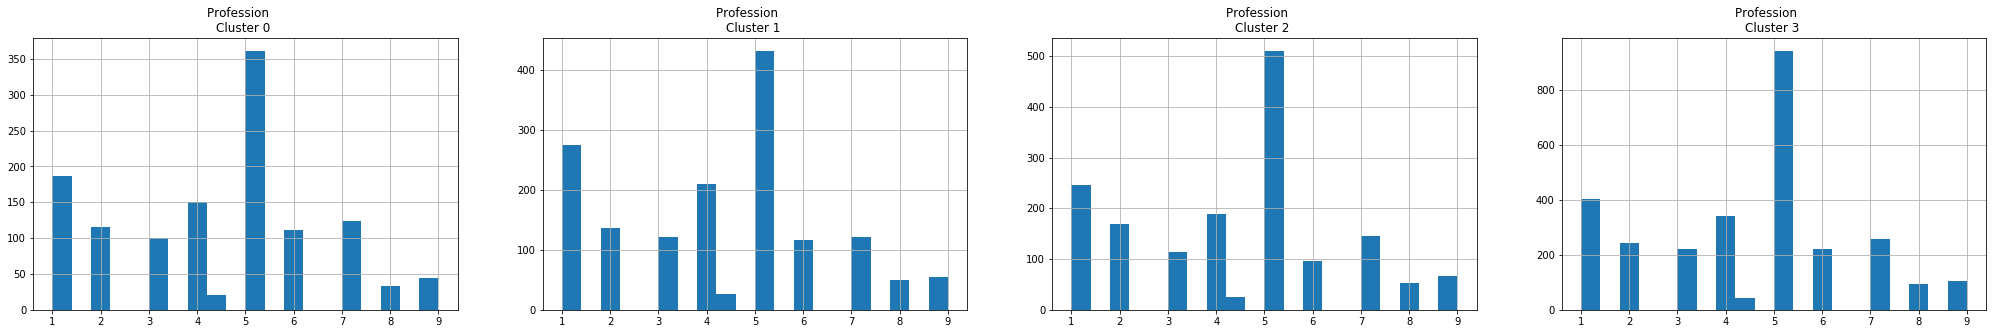

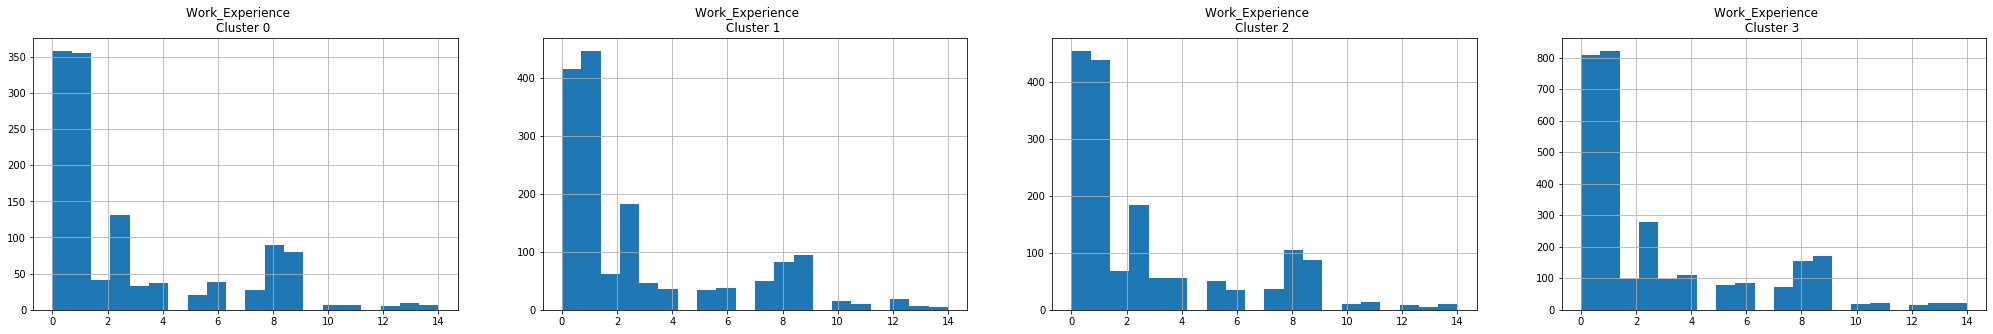

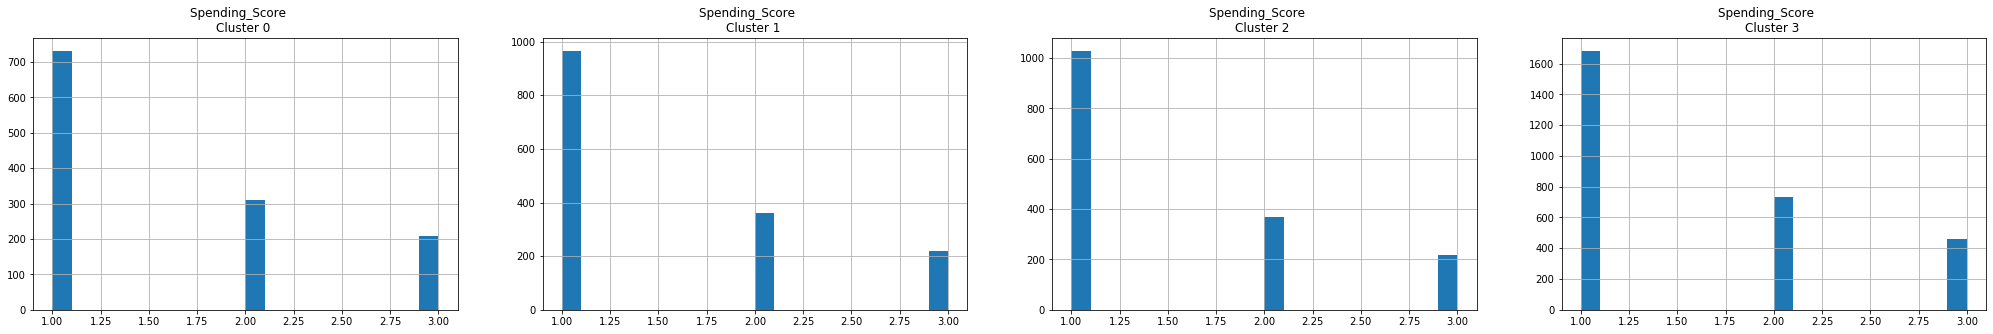

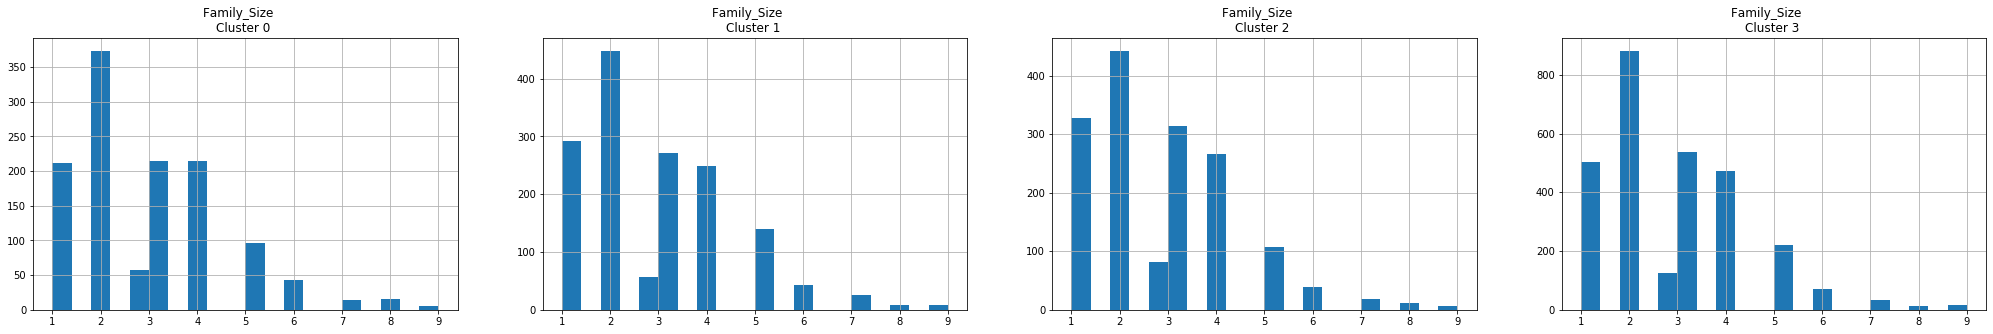

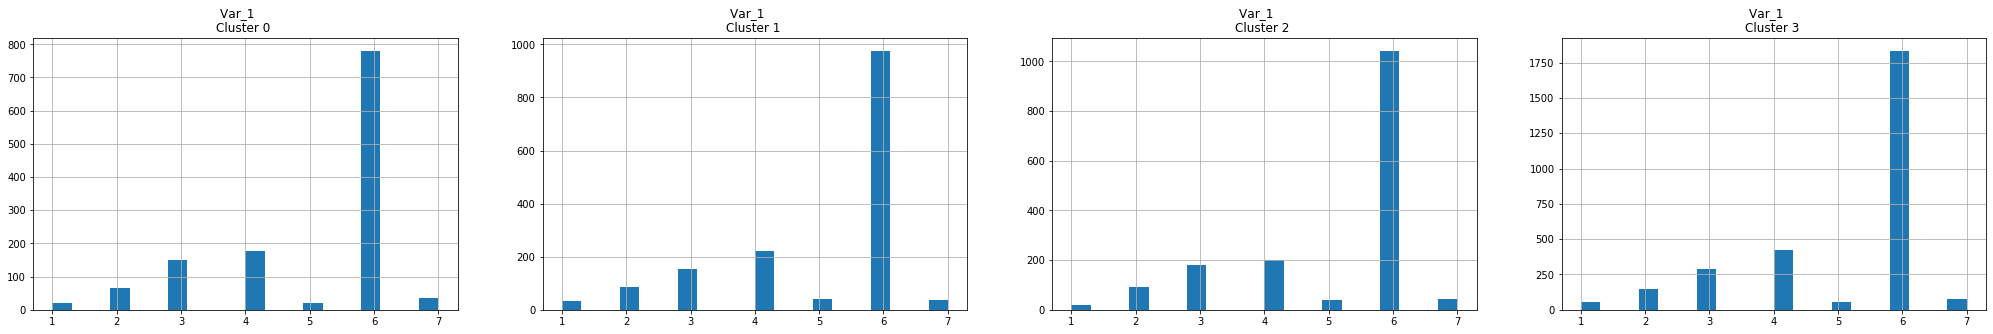

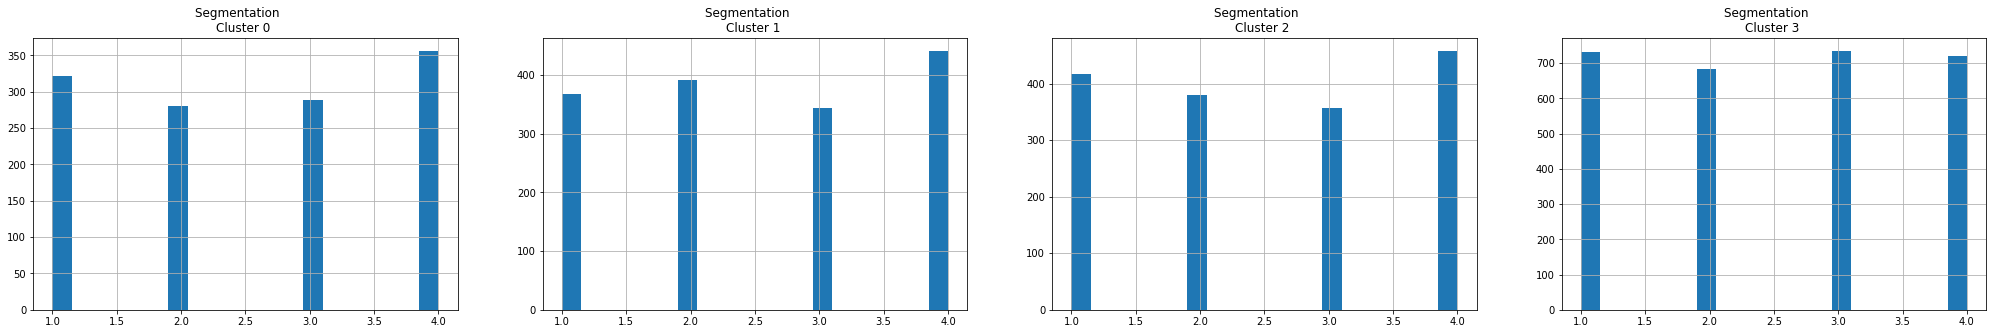

In [49]:
# Plot the histogram of various clusters
for i in train.columns:
  plt.figure(figsize = (35, 5))
  for j in range(4):
    plt.subplot(1,4,j+1)
    cluster = train_cluster[train_cluster['cluster'] == j]
    cluster[i].hist(bins = 20)
    plt.title('{}    \nCluster {} '.format(i,j))
  
  plt.show()